# Algoritmo de Máquinas de Vector Soporte Cuántico (QSVM)

En este notebook se recoge el codigo relativo al capitulo de descripcion del algoritmo de Support Vector Machines Cúanticas (SVM) del trabajo. El codigo generado se ha ejecutado en el BackEnd cuántico de IBM, pero es de propósito general y es eXportable a diferentes BackEnds cuánticos para ejecutarse en otras plataformas de computacion cuántica.

El codigo elaborado permite la realización de una serie de figuras que describen la naturaleza de los Kernels cuánticos, cómo pueden construirse y cómo pueden utilizarse con el algoritmo SVM clásico.

Para la construccion de Kernels cuánticos se utilizan las librerías **Quantum Advantage Seeker with Kernels (QuASK)** que permiten facilitar la construccion de Kernels cuánticos y su calculo ejecutándolo en diversos BackEnds cuánticos. Estas librerías incorporan también metricas de evaluacion de la calidad de los Kernels construidos y diferentes mecanismos de busqueda de Kernels óptimos utilizando técnicas heuristicas y de Machine Learning. Estas utilidades permiten el diseño de Kernels cuánticos de una forma sistemática y de calidad, evitando tener que diseñarlos desde bajo nivel y genrando un codigo mas susceptible de contener errores y desarrollado para un BackEnd específico. La documentacion de estas librerías puede encontrarse en [QuASK](https://quask.readthedocs.io/).

Se utilizan las librerías de numpy, pandas, matplotLib para la realizacion de calculos, tratamiento de datos y visualizacion. Se utilizan las librerías Scikit-Learn para las operaciones de Aprendizaje Máquina (Machine Learning) relativas al algoritmo SVM. Se utilizan las librerías de qiskit para la ejecucion de los circuitos cuánticos. Para la utilización de las librerías QuASK con el BackEnd de qiskit se requiere la instalación de una serie de librerías adicionales que se recogen en el fichero `requirements.txt`, con las versiones recogidas en el mismo para respetar las dependencias del código de QuASK.

In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_

In [2]:
#cargamos las librerias necesarias
import time, copy

#librerias de datos y visualizacion
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

#librerias de Machine Learning
#generacion datos de muestra
from sklearn.datasets import load_iris
#procesado y transformaciones
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
# "Support vector classifier"
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

#librerías QuASK para el diseño y calculo de Kernels cuánticos
import quask
from quask.core import Ansatz, Kernel, KernelFactory, KernelType
#BackEnd de qiskit
from quask.core_implementation import QiskitKernel

import warnings
warnings.filterwarnings('ignore')

## Kernels cuánticos

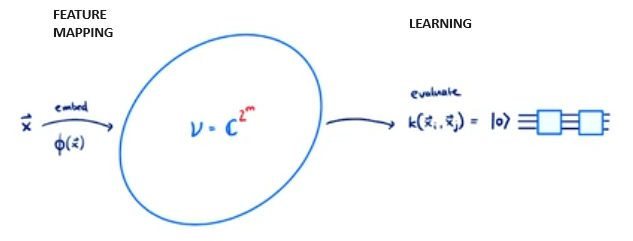

In [3]:
# Display the image
Image(filename="figuras/figura_q_1.png")

Hablar de que es y de la expresabilidad

[the expressibility and capacity of generating vectors in Hilbert space by different parametric circuits - pag25](http://dspace.isical.ac.in:8080/jspui/bitstream/10263/7375/1/Anubhav%20Trivedi%20%20MTech%20Dissertation%2028%207%2022%20-34.pdf)

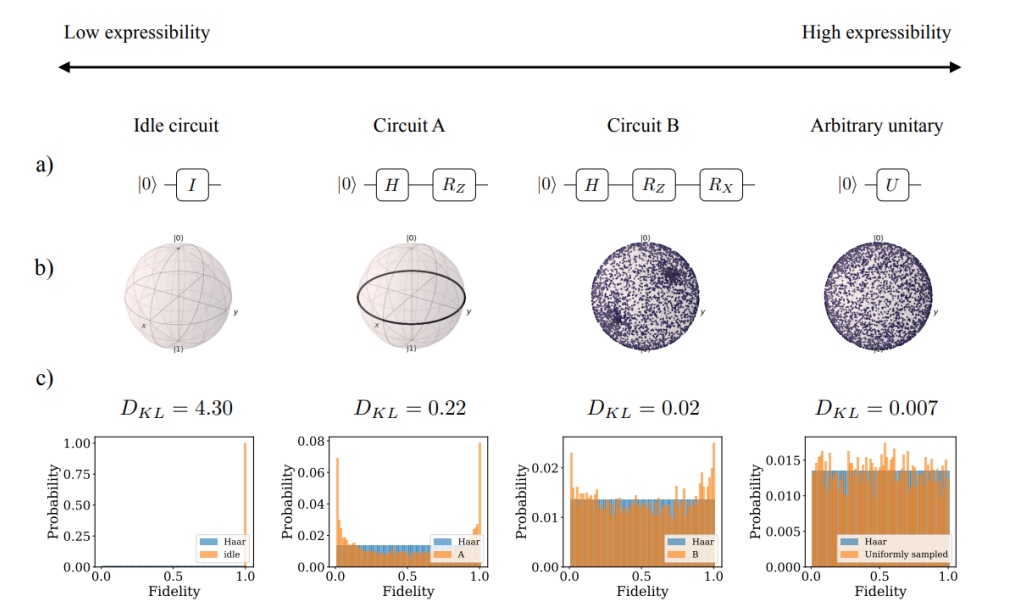

In [4]:
# Display the image
Image(filename="figuras/figura_q_2.png")

## QuASK

En este apartado se genera el codigo que explica el funcionamiento de las librerías **Quantum Advantage Seeker with Kernels (QuASK)** y como podemos utilizarlas para el diseño de Kernels cuánticos

Las librerías proporcionan tres clases principales que nos permiten generar objetos para definir y calcular los Kernels cuánticos:

- clase `Ansatz` funcion que mapea (feature map) los datos codificados de forma clásica al espacio de Hilbert (codificacion cuantica de los datos) utilizando un circuito cuantico. Los parametros de esta clase son:

  -- el numero de qubits del circuito cuantico, tipicamente se corresponde con el numero de caracteristicas de los datos clásicos aunque puede ser diferente

  -- el numero de puertas aplicadas en el circuito
  
  -- el numero de caracteristicas de los datos

- clase `Kernel` un objeto Kernel, que es un `Ansatz` más informacion adicional sobre como implementar el circuito cuantico de forma eficiente para todo el procedimiento. Este objeto puede ejecutarse en varios backends cuanticos, por ejemplo en Qiskit. Para ejecutarla en un BackEnd concreto hay que utilizar la subclase `KernelFactory`

- clase `KernelType` permite especificar diferentes formas para crear un kernel utilizando un `Ansatz` concreto. Esta clase es simplemente una enumeracion de distintos tipos de kernels que pueden implementarse.


In [5]:
# Number of features in the data point to be mapped in the Hilbert space of the quantum system
N_FEATURES = 1

# Number of gates applied to the quantum circuit
N_OPERATIONS = 1

# Number of qubits of the quantum circuit
N_QUBITS = 2

# Ansatz object, representing the feature map
ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)

La clase `Ansatz` tiene algunas propiedades interesantes:

- `n_features` numero de fratures de los datos
- `n_qubits` numero de qubits del circuito
- `n_operaciones` numero de puertas del circuito
- `operation_list`lista de operaciones definidas

In [6]:
print(ansatz.n_features)
print(ansatz.n_qubits)
print(ansatz.n_operations)
print(ansatz.operation_list)

1
2
1
[None]


Para usar la clase `Ansatz` necesita ser inicializada de manera que todas sus operaciones se correspondan con puertas válidas que operan sobre 2 qubits

In [7]:
#todas operaciones (solo definimos 1)
ansatz.initialize_to_identity()

Cada operacion que actua sobre 2 qubits viene especificada como:

$U(\beta\theta)= \exp(-i\beta\frac{\theta}{2}\sigma_1\sigma_2)$

donde los generadores $\sigma_1$ y $\sigma_2$ corresponden a las matrices de Pauli $X$,$Y$,$Z$ y la identidad $I$. Cuando uno de estos generadores es la identidad, la puerta actua sobre un solo qubit.

Este operador es paramétrico, con un parametre $\theta \in R$, que puede re-escalarse con el parametro global $0< \beta <1$

Utilizamos el metodo `change_operation` para definir una operacion en el objeto de la clase `Ansatz` que hemos creado e inicializado anteriormente.

```
    def change_operation(self, operation_index: int, new_feature: int, new_wires: List[int], new_generator: str, new_bandwidth: float):
        """
        Overwrite the operation at the given index with a whole new set of data
        :param operation_index: index of the operation
        :param new_feature: feature parameterizing the operation
        :param new_wires: wires on which the operation is applied
        :param new_generator: generator of the operation
        :param new_bandwidth: bandwidth of the operation
        :return: None
```

Este metodo nos permite definir la operacion mediante los siguientes parametros:
- `operation_index` un indice para manipular las operaciones definidas en el `Ansatz`
- `new_feature` la caracteristica de los datos que parametriza la rotacion, esto es, asignamos al valor de $\theta$ una caracteristica de los datos que definamos $0\leq i \leq$ N_FEATURES-1. O una caracteristica constante 1, para construir puestas no parametrizadas.
- `new_wires` los qubits sobre los que actua la operacion, representados como $(q_1,q_2)$ donde $0 \leq q_i \leq q_i <$ N_QBITS y $q_1 \neq q_2$.

- `new_generator` los operadores generadores $\sigma_1$ y $\sigma_2$ en forma de una cadena (p.ej. 'XY' para $\sigma_x$ y $\sigma_y$ respectivamente) que aplican a los qubits $(q_1,q_2)$. Si elegimos la identidad $I$ en uno o ambos qubits, en los elegidos no se realiza transformacion.

- `new_bandwidth` valor para el parametro de escaldo $\beta$



In [8]:
#cambiamos la operacion del valor inicializado (la identidad) a uno nuevo
#el indice de la operacion es 0, actua sobre los qubits 0 y 1 aplicando puertas sigma_x y el valor de escalado es 0.9
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.9)

Este es el **feature map** para calcular nuestro Kernel. Ahora para calcular los valores de **la matriz de Gram del Kernel** podemos especificar un metodo de calculo del producto escalar de todas las muestras de datos transformados por este feature map.

Los metodos de calculo que podemos implementar son:

- el test de fidelidad (fidelity test)
- el test de swap
- el valor esperado (expectation value) con respecto a algun observable

Adicionalmente tenemos que especificar el backend para realizar este calculo o medida.

### Crear Kernel I: utilizando un bak-end especifico

A partir de nuestro `Ansatz` vamos a construir nuestra funcion Kernel. Va a ser un objeto de la clase `Kernel` con informacion de implementacion en el BackEnd de Qiskit. En Quask hay los siguientes Backends disponibles Pennylane, Braket, Qibo y Qiskit.

Para crear en Qiskit el Kernel utilizamos la clase `QiskitKernel` que extiende la clase `Kernel` y le pasamos el `Ansatz`, la base de medida (tipicamente la base computacional) y el `KernelType` donde especificamos el metodo de calculo (p.ej. fidelity test) del Kernel.

In [9]:
kernel = QiskitKernel(ansatz, "Z" * N_QUBITS, KernelType.FIDELITY)

La clase `QiskitKernel` tiene algunos metodos interesantes y nos permite:

- `get_qiskit_ansatz` representar el circuito cuantico que implementa nuestro `Ansatz` en el BackEnd
- `to_numpy` exportar la matriz del Kernel a numpy
- `kappa` calcular los productos escalares de dos muestras de datos


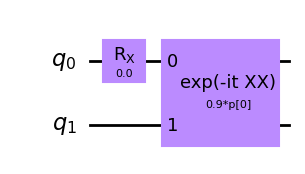

In [10]:
circuit=kernel.get_qiskit_ansatz()
display(circuit.draw(output="mpl", fold=-1))
circuit.draw(output="mpl", fold=-1).savefig('figuras/figura_q_3a.png')

In [11]:
#podemos exportar la matriz del Kernel a numpy
kernel.to_numpy()

array([5.0, 0.0, 1.0, 0.0, 0.9, 3, 3, 0], dtype=object)

In [12]:
# Para testear la funcion Kernel que hemos construido y que calcule el producto escalar de dos muestras transformadas

# recordamos como es nuestro circuito
print('n_features', ansatz.n_features)
print('n_qubits', ansatz.n_qubits)
print('n_operations', ansatz.n_operations)
print('operation_list', ansatz.operation_list)

# tenemos dos muestras con 1 features, nuestra operacion solo afecta a la feature 0 (new_feature=0 en la operacion del Ansatz)
x1 = np.array([0.001])
x2 = np.array([0.999])
print('data points: x1', x1, 'x2', x2)
similarity = kernel.kappa(x1, x2)
print("The kernel value between x1 and x2 is", similarity)

n_features 1
n_qubits 2
n_operations 1
operation_list [-i 0.90 * x[0] XX^(0,1)]
data points: x1 [0.001] x2 [0.999]
The kernel value between x1 and x2 is 0.3720703125


### Crear Kernel II: utilizando la clase `KernelFactory`

Usamos la clase `KernelFactory` que tiene un API de alto nivel que nos abstrae de los backends especificos y hace el codigo más portable para ejecutarse en cualquiera de ellos

De forma predeterminada, `KernelFactory` crea objetos que se basan en la simulación de disparo infinito y sin ruido de Pennylane como backend. Para usar la clase `KernelFactory` con un BackEnd especifico, primero especificamos dicho backend.

In [13]:
def create_qiskit_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(ansatz, measurement, type, n_shots=None)

#La siguiente instruccion solo se puede ejecutar una vez en el entorno, si da error comentar que ya esta ejecutada y cargada en memoria
KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
KernelFactory.set_current_implementation('qiskit_noiseless')

Despues contruimos el `Kernel` con el API de alto nivel `KernelFactory` y eso nos da como resultado un objeto de tipo `QiskitKernel` que podemos utilizar para calcular la funcion del Kernel

In [14]:
kernel = KernelFactory.create_kernel(ansatz, "Z" * N_QUBITS, KernelType.FIDELITY) # QiskitKernel
# recordamos como es nuestro circuito
print('n_features', ansatz.n_features)
print('n_qubits', ansatz.n_qubits)
print('n_operations', ansatz.n_operations)
print('operation_list', ansatz.operation_list)

# tenemos dos muestras con 1 features, nuestra operacion solo afecta a la feature 0 (new_feature=0 en la operacion del Ansatz)
x1 = np.array([0.001])
x2 = np.array([0.999])
print('data points: x1', x1, 'x2', x2)
similarity = kernel.kappa(x1, x2)
print("The kernel value between x1 and x2 is", similarity)

n_features 1
n_qubits 2
n_operations 1
operation_list [-i 0.90 * x[0] XX^(0,1)]
data points: x1 [0.001] x2 [0.999]
The kernel value between x1 and x2 is 0.3881526107367118


Los tipos de Kernel que podemos implementar con el mismo `Ansatz` pero diferente funcion de medida con el BackEnd de Qiskit serían los siguientes:

  - FIDELITY
  - OBSERVABLE
  - SWAP_TEST

Hemos calculado el primero, calculemos ahora los otros dos

In [15]:
#In the following example, the measurement is performed only on the first of two qubits.
kernel = KernelFactory.create_kernel(ansatz, "ZI", KernelType.SWAP_TEST)
x1 = np.array([0.001])
x2 = np.array([0.999])
print('data points: x1', x1, 'x2', x2)
similarity = kernel.kappa(x1, x2)
print("The kernel value between x1 and x2 is", similarity)

data points: x1 [0.001] x2 [0.999]
The kernel value between x1 and x2 is 0.6936376426942269


In [16]:
#We can also obtain the kernel by projecting onto a single observable described by a Pauli string.
kernel = KernelFactory.create_kernel(ansatz, "XY", KernelType.OBSERVABLE)
x1 = np.array([0.001])
x2 = np.array([0.999])
print('data points: x1', x1, 'x2', x2)
similarity = kernel.kappa(x1, x2)
print("The kernel value between x1 and x2 is", similarity)

data points: x1 [0.001] x2 [0.999]
The kernel value between x1 and x2 is -0.0152587890625


## Modelo de clasificacion con SVC y QKernel con datos reales

Para comprobar el funcionamiento de las librerías realizaremos un ejemplo de clasificacion con el algoritmo de SVM para el conjunto de datos de las flores IRIS que esta disponible en las librerias [scikit-learn](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)

Importamos los datos

In [17]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [18]:
X = iris_data.data
y = iris_data.target

print(X.shape)

(150, 4)


Dividimos el conjunto de datos en datos de entrenamiento (80%) y datos de test (20%)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Escalamos los datos a un rango $[0,1]$ para mejorar el comportamiento del clasificador con la clase [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) de scikit-learn

Aqui es importante tener en cuenta que elscalador se entrena con los datos de entrenamiento y se aplica a los datos de test, para obtener unos resultados rigurosos en la clasificacion.

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Definimos el modelo de Machine Learning, algoritmo Support Vector Machines Classifier [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) con un kernel, por lo que especificamos la opcion `precomputed` que indica que pasaremos al algoritmo la kernel `matriz de Gram` en lugar de los datos originales

In [21]:
# Instantiate a machine learning model
model = SVC(kernel='precomputed')

Calculamos nuestra `matriz de Gram` con un kernel cuantico definido en este caso para datos con 4 características, con un circuito de 4 qubits y aplicando 4 operaciones que son en realidad la misma operacion aplicada a 4 parejas de qubits y que consisten en un operador con $\beta=0.9$ y los operadores $\sigma_x$ y $\sigma_x$

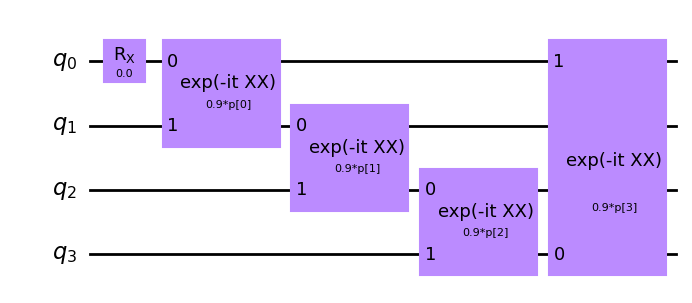

In [22]:
# Calculate the kernel Gram matrices
# Create a quantum kernel
ansatz = Ansatz(n_features=4, n_qubits=4, n_operations=4)
ansatz.initialize_to_identity()
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.9)
ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XX", new_bandwidth=0.9)
ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XX", new_bandwidth=0.9)
ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="XX", new_bandwidth=0.9)
kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)
circuit=kernel.get_qiskit_ansatz()
display(circuit.draw(output="mpl", fold=-1))
circuit.draw(output="mpl", fold=-1).savefig('figuras/figura_q_3b.png')

In [26]:
# Fit the model to the training data
start = time.time()
K_train = kernel.build_kernel(X_train_scaled, X_train_scaled)
model.fit(K_train, y_train)
end = time.time()

print('train - time elapsed', (end-start)/60 ,'min')

train - time elapsed 10.819460566838583 min


Una vez entrenado el modelo con las muestras de entrenamiento, realizamos la prediccion sobre el conjunto de datos de test y mediremos la calidad de la prediccion con las metricas de clasificacion de la matriz de confusion [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) sobre el conjunto de datos de test

In [27]:
# Predict the labels for the test data
start = time.time()
K_test = kernel.build_kernel(X_test_scaled, X_train_scaled)
y_test_pred = model.predict(K_test)
end = time.time()
print('prediction - time elapsed', (end-start)/60 ,'min')

prediction - time elapsed 2.4998520731925966 min


Total Accuracy (for all classes): 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



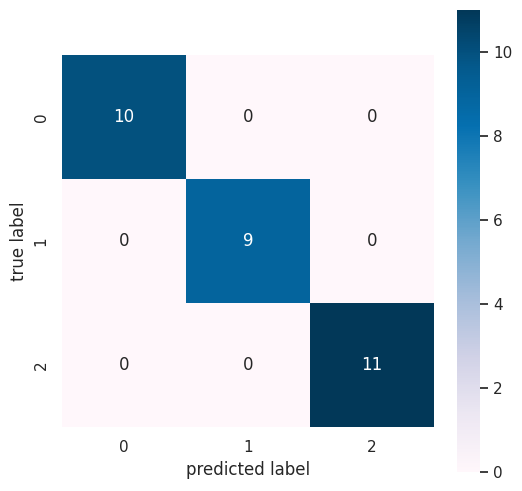

In [28]:
###METRICAS CLASIFICACION#######################
# Calculate the accuracy
accuracy = np.sum(y_test == y_test_pred) / len(y_test)
print("Total Accuracy (for all classes):", accuracy)

#confussion matrix metrics
print(metrics.classification_report(y_test,y_test_pred))

#confusion matrix plot
plt.figure(figsize=(6, 6))
sn.set()
mat = confusion_matrix(y_test,y_test_pred)
sn.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='PuBu')
plt.xlabel('predicted label')
plt.ylabel('true label');

Podemos guardar las `matrices de Gram` en un fichero para no tener que volver a calcularlas:

In [29]:
# Guardar las matrices en archivos .npy
np.save('kernels/kernel_iris/K_train_iris.npy', K_train)
np.save('kernels/kernel_iris/K_test_iris.npy', K_test)

FileNotFoundError: [Errno 2] No such file or directory: 'kernels/kernel_iris/K_train_iris.npy'

Y simplemente importarlas cuando sea conveniente:

In [ ]:
# Cargar las matrices desde los archivos .npy
K_train_cargada = np.load('kernels/kernel_iris/K_train_iris.npy')
K_test_cargada = np.load('kernels/kernel_iris/K_test_iris.npy')

Podemos visualizar el Kernel calculado con nuestro circuito cuantico para este conjunto de datos:

In [ ]:
#Las matrices de Gram para los conjuntos de datos de train y test
#K_train=K_train_cargada
#K_test=K_test_cargada
print('Training Gram matrix', K_train)
print('Testing Gram matrix ', K_test)

#visualizacion como imagenes de los valores de las matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

im=axs[0].imshow(
    np.asmatrix(K_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")
fig.colorbar(im)

im=axs[1].imshow(np.asmatrix(K_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")

fig.colorbar(im)
fig.savefig('figuras/figura_q_5.png')

## Criterios para evaluar un Kernel cuántico

Una de las principales características del **QuASK** es la posibilidad de evaluar un Kernel cuántico según diversos criterios propuestos en la literatura. Estos criterios son especialmente importantes en el contexto de la búsqueda de una ventaja cuántica, un modelo que supere las opciones clásicas existentes.

Las librerías presentan algunos errores de código en los evaluadores **CoveringNumberEvaluator** y **EssModelComplexityEvaluator** que deben de corregirse en las clases de estos para que puedan utilizarse correctamente. En el codigo que demuestra su utilización se muestra tambien las correcciones que hay que realizar en las librerías para conseguir su funcionamiento.

Todos los criterios están disponibles como clases que heredan la clase abstracta `KernelEvaluator`. Este objeto tiene sólo un método abstracto, evaluar, que toma cuatro argumentos:

- El objeto del kernel.

- El conjunto de datos de entrenamiento X, que podrían ser utilizados por algunos criterios de evaluacion.

- El conjunto de etiquetas y, que podrían ser utilizadas por algunos criterios junto con los datos de entrenamiento.

- La matriz Gram K del Kernel, que es completamente opcional y se puede construir a partir de kappa y X.

El argumento K se proporciona en caso de que dicho objeto haya sido ya calculado previamente y se conserve con el fin de acelerar el cálculo.

Demostramos un posible método para evaluar nuestro kernel cuántico con respecto a diferentes metodos:

1) Dependiendo solamente del circuito (`Ansatz`)

 En general son metodos donde lo deseable es que la expresibilidad del circuito y por tanto su complejidad sean lo mas bajas posibles.

- **Haar Evaluator**: calcula los estados que puede generar el circuito frente a una distribucion de estados aleatorios en el espacio. Cuanto mas similitud tenga esta comparacion, mas expresabilidad tiene el circuito. (the lower cost values corresponds to better solutions) [the expressibility would increase with decrease of Haar evaluation result - pag25](http://dspace.isical.ac.in:8080/jspui/bitstream/10263/7375/1/Anubhav%20Trivedi%20%20MTech%20Dissertation%2028%207%2022%20-34.pdf)
- **Dynamical Lie Algebra**: Es el rango del algebra de Lie asociada al circuito, truncada a un valor maximo. Indica la expresabilidad del circuito (mayor valor, mayor expresabilidad) y la eficiencia de simulacion en computacion clasica (mayor valor, mas dificil de simular).(the lower cost values corresponds to better solutions)
- **CoveringNumberEvaluator**: Mide la expresibilidad dando una cota a partir del numero de puertas del circuito. (the lower cost values corresponds to better solutions)

2) Dependiendo del circuito (`Ansatz`) y de los datos de entrenamiento, pero no de las etiquietas

- **GeometricDifferenceEvaluator**: Esta medida compara un conjunto de Kernels clásicos $K_C$ con un Kernel cuántico $K_Q$. Si el valor de este parametro es minimo para algun Kernel clásico, significa que se parece al cuantico y tendran similares resultados. Si el valor es proximo a $\sqrt m$ (con $m$ el numero de muestras del conjunto de datos) significa que el KErnel Cuantico no se parece a los clasicos, es muy diferente y por lo tanto puede ofrecer ventaja cuantica (si el modelo clasico es simple, no tendra problemas de la maldicion de dimensionalidad y el cuantico puede no ofrecer ventaja, pero si el clasico es complejo y el cuantico no, seguramente habra ventaja, si el cuantico es tambien complejo puede que no de tampoco ventaja y tenga los mismos problemas que el clasico). (characterize the separation between classical and quantum kernels.)

3) Dependiendo del circuito (`Ansatz`) de los datos de entrenamiento y de las etiquietas

- **CenteredKernelAlignment**:

- **KernelAlignmentEvaluator**:

- **RidgeGeneralizationEvaluator**:

- **EssModelComplexityEvaluator**:

- **SpectralBiasEvaluator**:


In [30]:
from quask.evaluator import HaarEvaluator, LieRankEvaluator, CoveringNumberEvaluator
from quask.evaluator import GeometricDifferenceEvaluator
from quask.evaluator import CenteredKernelAlignmentEvaluator, KernelAlignmentEvaluator, RidgeGeneralizationEvaluator, EssModelComplexityEvaluator, SpectralBiasEvaluator

print('1- Evaluating the `Ansatz`')
#the lower the better
start = time.time()
he = HaarEvaluator(n_bins=40, n_samples=10000)
cost = he.evaluate(kernel=kernel, K=None, X=None, y=None)
print(f"Cost (norm of A): {cost:3.5f}")
end = time.time()
print('Calculation time',(end-start)/60 ,'min')
#Cost (norm of A): 0.13593
#Calculation time 6.8179036776224775 min

start = time.time()
lre = LieRankEvaluator(T=500)
cost = lre.evaluate(kernel=kernel, K=None, X=None, y=None)
print(f"Cost (-1 * rank of DLA): {cost:3.5f}")
end = time.time()
print('Calculation time',(end-start)/60 ,'min')


start = time.time()
cn_eval = CoveringNumberEvaluator()
cost = cn_eval.evaluate(kernel=kernel, K=None, X=None, y=None)
print(f"Cost (number of gates): {cost:3.5f}")
end = time.time()
print('Calculation time',(end-start)/60 ,'min')


print('2- Evaluating `Ansatz` and training data')
#GeometricDifferenceEvaluator needs a list of classic kernels


print('3- Evaluating `Ansatz` training data and labels')
#one can input kernel and X or K_train-scaled instead
#some requiere both -inneficient check source code
start = time.time()
ka = KernelAlignmentEvaluator()
cost = ka.evaluate(kernel=None, K=K_train, X=None, y=y_train)
print("The cost according to the KTA is:", cost)
end = time.time()
print('Calculation time',(end-start)/60 ,'min')

start = time.time()
ce = CenteredKernelAlignmentEvaluator()
cost = ce.evaluate(kernel=None, K=K_train, X=None, y=y_train)
print("The cost according to the Centered-KTA is:", cost)
end = time.time()
print('Calculation time',(end-start)/60 ,'min')

start = time.time()
ridge_eval = RidgeGeneralizationEvaluator()
cost = ridge_eval.evaluate(kernel=kernel, K=K_train, X=X_train_scaled, y=y_train)
print("The cost according to the Ridge Generalization is:", cost)
end = time.time()
print('Calculation time',(end-start)/60 ,'min')

start = time.time()
smc_eval = EssModelComplexityEvaluator()
cost = smc_eval.evaluate(kernel=None, K=K_train, X=None, y=y_train)
print("The cost according to the S-model complexity is:", cost)
end = time.time()
print('Calculation time',(end-start)/60 ,'min')

start = time.time()
sb_eval = SpectralBiasEvaluator(10)
cost = sb_eval.evaluate(kernel=kernel, K=K_train, X=X_train_scaled, y=y_train)
print("The cost according to SpectralBiasEvaluator is:", cost)
end = time.time()
print('Calculation time',(end-start)/60 ,'min')

1- Evaluating the `Ansatz`
Cost (norm of A): 0.13524
Calculation time 6.871306188901266 min
Cost (-1 * rank of DLA): -8.00000
Calculation time 6.973743438720703e-06 min


TypeError: unsupported operand type(s) for ** or pow(): 'int' and 'list'

## Optimizacion de Kernels cuánticos

Las librerías **QuASK** vienen provistas de una serie de clases que nos ayudan en el diseño de Kernels cuánticos óptimos. Estas clases son optimizadores que desarrollan un proceso de búsqueda de posibles Kernels cuánticos guiados por una funcion de coste que se basa en alguna de las métricas de evaluacion disponibles. El usuario puede tambien definir su propia métrica de evaluacion y funcion de coste y por supuesto su propia clase de optimizacion.

En QuASK un optimizador comienza la búsqueda de un Kernel óptimo desde el Kernel inicial y procede iterativamente durante un numero de tentativas deseado, cambiando el Kernel y evaluando si se trata de un Kernel mejor. Cuando el resultado de la evaluacion mejora, indicando un menor costo para el evaluador del kernel, se acepta la nueva solución. Esta es una forma automática de optimizar el Kernel cuántico, y a continuación se muestran técnicas más sofisticadas.

El paquete `quask.optimizer` permite definir un procedimiento de optimización para Kernels cuánticos. La interfaz principal es la clase `BaseKernelOptimizer`, que requiere:

* una función del Kernel, que servirá como punto inicial de la rutina de optimización;
* un evaluador del Kernel, que será la función de costes que guiará la optimización;
* posiblemente algunos datos de entrada, si los necesita el evaluador del Kernel.

Devuelve una nueva instancia de `quask.core.Kernel` para ser utilizada en el algoritmo SVC

Las librerías **QuASK** vienen provistas de los siguientes optimizadores que funcionan correctamente:

- **RandomOptimizer**: La función de optimización comienza con un Kernel inicial aleatorio y procede iterativamente N_TENTATIVES veces cambiando una sola operación dentro del circuito cuántico con una operación completamente aleatoria. Cuando el resultado mejora, indicando un menor costo para el evaluador del kernel, se acepta la nueva solución. Claramente, esta es una forma bastante ineficiente de optimizar el Kernel cuántico.

- **BayesianOptimizer**: La optimización bayesiana es la técnica más sencilla y, normalmente, la más eficaz de utilizar. Se utiliza una funcion de coste que se basa en una metrica de evaluacion y las librerias [scikit-optimize](https://scikit-optimize.github.io/stable/) para hacer la búsqueda del Kernel óptimo. Se sabe que funciona mejor para problemas de baja dimensión donde la función a optimizar es costosa de evaluar.

El resto de los optimizadores (**MetaheuristicOptimizer**, **GreedyOptimizer**, **ReinforcementLearningOptimizer**) dan problemas de ejecución y no pueden utilizarse directamente con la instalacion de las librerías. El optimizador greedy aunque no esta disponible, es sencillo de implementar.


### Optimizador aleatorio

In [ ]:
#Random Optimizer
from quask.optimizer.base_kernel_optimizer import BaseKernelOptimizer
from quask.evaluator import CenteredKernelAlignmentEvaluator

class RandomOptimizer(BaseKernelOptimizer):

    def __init__(self, initial_kernel, X, y, ke):
        super().__init__(initial_kernel, X, y, ke)

    def optimize(self):
        #starts from the initial kernel
        kernel = copy.deepcopy(self.initial_kernel)
        cost = self.ke.evaluate(kernel, None, self.X, self.y)
        N_TENTATIVES = 2
        #proceeds iteratively N_TENTATIVES times by changing a single operation within the quantum circuit with a completely random operation
        for i in range(N_TENTATIVES):
            start = time.time()
            new_kernel = copy.deepcopy(kernel)
            i_operation = np.random.randint(new_kernel.ansatz.n_operations)
            i_feature = np.random.randint(new_kernel.ansatz.n_features)
            i_wires = np.random.choice(range(new_kernel.ansatz.n_qubits), 2, replace=False).tolist()
            i_gen = np.random.choice(['I', 'Z', 'X', 'Y'], 2, replace=True)
            i_gen = "".join(i_gen.tolist())
            i_bandwidth = np.random.rand()
            new_kernel.ansatz.change_operation(i_operation, i_feature, i_wires, i_gen, i_bandwidth)
            new_cost = self.ke.evaluate(new_kernel, None, self.X, self.y)
            end = time.time()
            duration=(end-start)/60
            print('Random params', i_operation, i_feature, i_wires, i_gen, i_bandwidth)
            print("Cost of the new solution:", new_cost,"time duration", duration,"min.")
            if cost > new_cost:
                kernel = new_kernel
                cost = new_cost
        return kernel

N_FEATURES = 4
N_OPERATIONS = 5
N_QUBITS = 4
ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
ansatz.initialize_to_identity()
kernel = KernelFactory.create_kernel(ansatz, "Z" * N_QUBITS, KernelType.FIDELITY)

#evaluator
ce = CenteredKernelAlignmentEvaluator()
print("The initial cost is:", ce.evaluate(kernel, None, X_train_scaled, y_train))
optimizer = RandomOptimizer(kernel, X_train_scaled, y_train, ce)
optimized_kernel = optimizer.optimize()
print("The final cost is:", ce.evaluate(optimized_kernel, None, X_train_scaled, y_train))

The initial cost is: -0.053702924048742884
Random params 2 3 [0, 2] IX 0.6690298890046601
Cost of the new solution: -0.35858574652308717 time duration 4.907367090384166 min.
Random params 3 1 [0, 3] YZ 0.6713441295689652
Cost of the new solution: -0.33805254141083885 time duration 6.66217208703359 min.
The final cost is: -0.35858574652308717


### Optimizador bayesiano

In [ ]:
from quask.optimizer.bayesian_optimizer import BayesianOptimizer

print("The initial cost is:", ce.evaluate(kernel, None, X_train, y_train))
optimizer = BayesianOptimizer(kernel, X_train_scaled, y_train, ce)
optimized_kernel = optimizer.optimize(n_epochs=2, n_points=1, n_jobs=1)
print("The final cost is:", ce.evaluate(optimized_kernel, None, X_train_scaled, y_train))

The initial cost is: -0.05316033140782663


/usr/local/lib/python3.10/dist-packages/quask/core_implementation/qiskit_kernel.py:81: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  qc.append(self.get_qiskit_ansatz().bind_parameters(x1.tolist() + [1.0]), range(self.ansatz.n_qubits))


Epoch of training i=0


/usr/local/lib/python3.10/dist-packages/quask/core_implementation/qiskit_kernel.py:81: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  qc.append(self.get_qiskit_ansatz().bind_parameters(x1.tolist() + [1.0]), range(self.ansatz.n_qubits))


Epoch of training i=1
The final cost is: -0.3414050886338144
